# Using data to decide where to open a new coffee shop

## Analysis based on Helsinki capital region open data

![Coffee shop](jazmin-quaynor-9Y8vxVQN4o4-unsplash_s.png)



## Data

Data from several sources will be combined for this analysis. The main data sources will be the statistics institute of Finland (stat.fi), and the helsinki region infoshare site (hri.fi). Foursquare places API (https://developer.foursquare.com/docs/places-api/) will also be used to get data about the different venues around the region.

### Map data
The map data about the postal areas can be fetched from here: https://hri.fi/data/fi/dataset//paakaupunkiseudun-postinumeroalueet

The map data was in KML format and was converted to GeoJSON format using python package "kml2geojson".

### Economics data

The main economics data about the region can be fetched from here.

https://pxnet2.stat.fi/PXWeb/pxweb/fi/Postinumeroalueittainen_avoin_tieto/Postinumeroalueittainen_avoin_tieto__2020/paavo_pxt_12f1.px/

One challenge is that the coordinate data about the postal code areas is in EUREF-FIN -format. This data has to be converted to the international WGS84 coordinate system so that it can be fed to the Foursquare API. For this conversion I will be using python package "pyproj".

We will use the economics data to clearly define what kind of population lives in the different areas, and what kind of buying power they have. We will also try to look into the amount of offices and businesses versus homes, hypothesis being that if there are offices nearby maybe the workers would use the cafe during the office hours.

### The venue data

For the venue data we will be using Foursquare API (https://developer.foursquare.com/docs/places-api/). The venue data will help to establish knowledge of the existing competition and other venues as well. To match the venue data to the postal code areas we would need the coordinates for the approximate center of each postal code.


## Let's look into the data more closely

In [1]:

import pandas as pd
import folium
import json
import seaborn as sns
from matplotlib import pyplot as plt



In [2]:
# Let's get the general postal area data into a dataframe
postalareas_df = pd.read_csv("009_12f7_2021.csv",skiprows=2, encoding='ansi')

# split 'Postinumeroalue' into postal code and area name
postalareas_df[['Postalcode','Areaname']] = postalareas_df.Postinumeroalue.str.split(" ", n=1,expand=True)

# drop the old 'Postinumeroalue' column
postalareas_df = postalareas_df.drop('Postinumeroalue',axis=1)

# strip the city name from the areanames
postalareas_df['Areaname'] = postalareas_df['Areaname'].map(lambda x: x.replace(' (Helsinki)','').replace(' (Vantaa)','').replace(' (Espoo)','').replace(' (Kauniainen)',''))

# show results
postalareas_df.head()



,X-koordinaatti metreinä,Y-koordinaatti metreinä,Postinumeroalueen pinta-ala,"Asukkaat yhteensä, 2019 (HE)","Miehet, 2019 (HE)","Naiset, 2019 (HE)","Asukkaiden keski-ikä, 2019 (HE)","0-2-vuotiaat, 2019 (HE)","3-6-vuotiaat, 2019 (HE)","7-12-vuotiaat, 2019 (HE)",...,"X Toimiala tuntematon, 2018 (TP)","Asukkaat yhteensä, 2018 (PT)","Työlliset, 2018 (PT)","Työttömät, 2018 (PT)","Lapset 0-14 -vuotiaat, 2018 (PT)","Opiskelijat, 2018 (PT)","Eläkeläiset, 2018 (PT)","Muut, 2018 (PT)",Postalcode,Areaname
0,384979,6672361,2353278,18334,8661,9673,41,402,507,723,...,3,18427,10576,607,1846,1227,3420,751,00100,Helsinki Keskusta - Etu-Töölö
1,385531,6671434,414010,7140,3379,3761,41,151,232,333,...,0,7161,4081,241,829,419,1243,348,00120,Punavuori
2,386244,6671474,428960,1582,763,819,41,41,45,72,...,0,1523,876,37,172,86,266,86,00130,Kaartinkaupunki
3,386394,6670766,931841,7958,3625,4333,42,192,259,423,...,0,7921,4251,261,986,459,1530,434,00140,Kaivopuisto - Ullanlinna
4,385320,6670373,1367328,9420,4323,5097,40,221,268,406,...,0,9385,5514,364,957,527,1544,479,00150,Eira - Hernesaari


In [3]:
# How many many postal code areas are there?
print("Count of postal code areas is {}".format(postalareas_df.shape[0]))

Count of postal code areas is 168


### Let's see the distribution of the postal code area sizes by the number of inhabitants

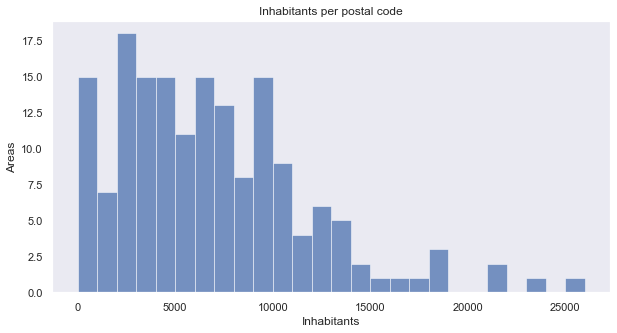

In [4]:
sns.set_theme(style="dark")
fig, ax = plt.subplots(figsize=(10,5))
pop_chart = sns.histplot(
    ax = ax,
    x="Asukkaat yhteensä, 2019 (HE)",
    data=postalareas_df,
    bins=20,
    binwidth=1000,
    linewidth=.5
)
pop_chart.set_title('Inhabitants per postal code')
plt.xlabel("Inhabitants")
plt.ylabel("Areas")
pop_chart.frameon = False

So most postal code areas are between 0 and 10000 inhabitants, with some areas going up to 25000 inhabitants.

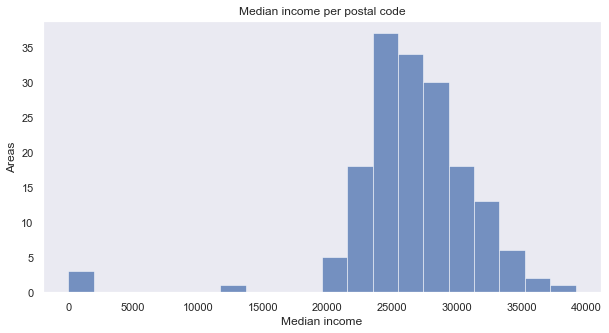

In [5]:
# Let's see the median income distribution

fig, ax = plt.subplots(figsize=(10,5))
pop_chart = sns.histplot(
    x="Asukkaiden mediaanitulot, 2019 (HR)",
    data=postalareas_df,
    bins=20,
    linewidth=.5
)
pop_chart.set_title('Median income per postal code')
plt.xlabel("Median income")
plt.ylabel("Areas")
pop_chart.frameon = False